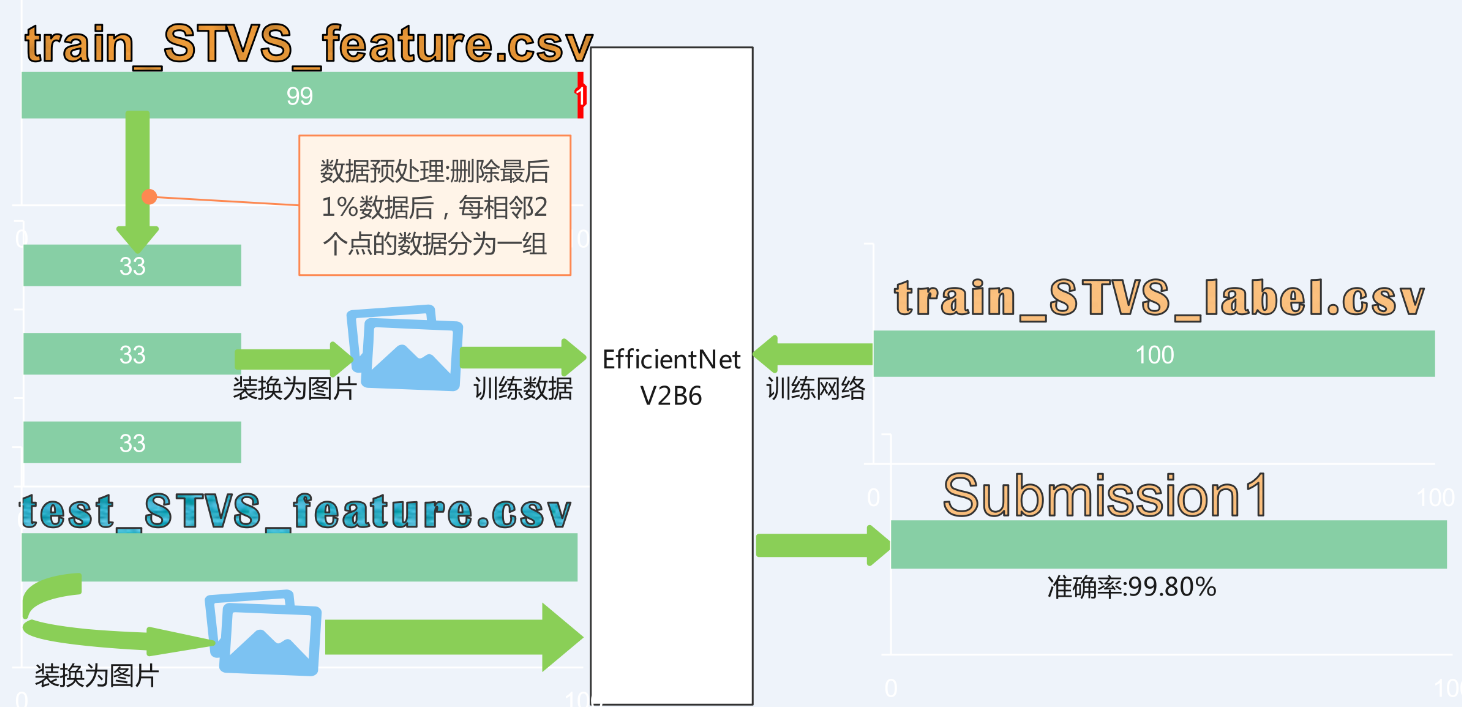

# 初赛

## 数据预处理

In [ ]:
'''
在此定义是否使用已经训练好的模型和处理好的数据:
if_pretrain = False则不使用处理好的数据，预训练模型，预计用时：2h18min
if_pretrain = True则使用处理好的数据，预训练模型，预计用时：
'''
if_pretrain = True

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch

if(if_pretrain==False):
    #最开始的官方给定的原数据
    train_origion=pd.read_csv('../input/tianchi-unilab/data_train_r1/train_STVS_feature.csv',header=None)
    label_origion=pd.read_csv('../input/tianchi-unilab/data_train_r1/train_STVS_label.csv',header=None)
    test_origion = pd.read_csv('../input/tianchi-unilab/data_test_r1/test_STVS_feature.csv',header=None)

### 将原数据一分为多

In [ ]:
if(if_pretrain==False):
    #测试集的数据缺失了70%，为了使数据维度一致并增加训练样本，将训练集每隔2列取一个点，分为3份数据
    idx1=[]    #第一份数据索引
    idx2=[]    #第二份数据索引
    idx3=[]    #第三份数据索引

    idx=[]    #新生成数据索引
    for j in range(33):        #获取数据的索引
        for i in range(1,40):
            idx1.append(i+0+117*j-1)
            idx2.append(i+39+117*j-1)
            idx3.append(i+78+117*j-1)

            idx.append(i+39*j-1)

    step = 3900 - 39
    for k in range(13):
        idx1.append(step + 0 + 3*k )
        idx2.append(step + 1 + 3*k )
        idx3.append(step + 2 + 3*k )

        idx.append(1287+k)


    print(len(idx1),len(idx2),len(idx3),len(idx))    
    #根据索引获取数据
    train1=train_origion.iloc[:,idx1]
    train1.columns=idx
    train2=train_origion.iloc[:,idx2]
    train2.columns=idx
    train3=train_origion.iloc[:,idx3]
    train3.columns=idx


    #生成新数据及其索引
    train_three=pd.concat([train1,train2,train3],axis=0,ignore_index=True)
    label_three=pd.concat([label_origion,label_origion,label_origion],axis=0,ignore_index=True)

### 将数据装换为图片

In [ ]:
size = 224
#### 将数据装换成图片形式，每一行数据生成一张（1，size，size）的图片
def to_image(data):
    index = data.shape[0]
    columns= data.shape[1]
    target = np.zeros((index,size, size)) 
    scale = columns / size
    #for i in tqdm(range(index)):
    for i in tqdm(range(index)):
        for j in range(columns):
            h = size-1- int(data.iloc[i,j] * 100)
            w = int(j//scale)
            target[i,h,w] += int(1)
    return target

In [ ]:
if(if_pretrain==False):
    #数据装换为图片
    train_data=to_image(train_three)
    test_data=to_image(test_origion)
    
    np.save('./test_data.npy',test_data)

### label的处理

In [ ]:
if(if_pretrain==False):
    #将标签处理为分类问题的标签
    label=pd.concat([label_three,-label_three],axis=1)
    torch_label=label.copy()
    for i in tqdm(range(len(torch_label))):
        if(torch_label.iloc[i,0]==-1):
            torch_label.iloc[i,0]=0
        if(torch_label.iloc[i,1]==-1):
            torch_label.iloc[i,1]=0
    

In [ ]:
if(if_pretrain==False):
    import gc
    del label,train_three,label_three,train_origion,label_origion,test_origion
    gc.collect()
    train_data.shape,test_data.shape,torch_label.shape

In [ ]:
if(if_pretrain==True):
    test_data=np.load('../input/tianchi-unilab/data_test_r1/test_data.npy')

### 定义数据集

In [ ]:
if(if_pretrain==False):
    import torch
    from torch.utils.data import Dataset

    class Mydataset(Dataset):
        def __init__(self,data1,label1):
            self.data = torch.tensor(data1).to(torch.float32)
            self.label = torch.tensor(label1.values).to(torch.float32)

        def __getitem__(self, index):
            x= self.data[index]
            y= self.label[index]
            return torch.unsqueeze(x,0), y

        def __len__(self):
            return len(self.label)

    '''  
    from sklearn.model_selection import train_test_split
    x_train,x_test,y_train,y_test = train_test_split(train_data,torch_label)

    #评估模型时训练数据
    train_dataset = Mydataset(x_train,y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=1, shuffle=True,num_workers=0)

    #评估模型使验证数据
    validate_dataset = Mydataset(x_test,y_test)
    validate_loader=torch.utils.data.DataLoader(validate_dataset,batch_size=1, shuffle=True,num_workers=0)
    '''

    #训练模型时所有数据
    train_dataset_total = Mydataset(train_data,torch_label)
    train_loader_total = torch.utils.data.DataLoader(train_dataset_total,batch_size=1, shuffle=True,num_workers=4,pin_memory=True)

## 模型评估

### 定义卷积神经网络

In [ ]:
"""utils.py - Helper functions for building the model and for loading model parameters.
   These helper functions are built to mirror those in the official TensorFlow implementation.
"""

# Author: lukemelas (github username)
# Github repo: https://github.com/lukemelas/EfficientNet-PyTorch
# With adjustments and added comments by workingcoder (github username).

import re
import math
import collections
from functools import partial
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import model_zoo


################################################################################
# Help functions for model architecture
################################################################################

# GlobalParams and BlockArgs: Two namedtuples
# Swish and MemoryEfficientSwish: Two implementations of the method
# round_filters and round_repeats:
#     Functions to calculate params for scaling model width and depth ! ! !
# get_width_and_height_from_size and calculate_output_image_size
# drop_connect: A structural design
# get_same_padding_conv2d:
#     Conv2dDynamicSamePadding
#     Conv2dStaticSamePadding
# get_same_padding_maxPool2d:
#     MaxPool2dDynamicSamePadding
#     MaxPool2dStaticSamePadding
#     It's an additional function, not used in EfficientNet,
#     but can be used in other model (such as EfficientDet).

# Parameters for the entire model (stem, all blocks, and head)
GlobalParams = collections.namedtuple('GlobalParams', [
    'width_coefficient', 'depth_coefficient', 'image_size', 'dropout_rate',
    'num_classes', 'batch_norm_momentum', 'batch_norm_epsilon',
    'drop_connect_rate', 'depth_divisor', 'min_depth', 'include_top'])

# Parameters for an individual model block
BlockArgs = collections.namedtuple('BlockArgs', [
    'num_repeat', 'kernel_size', 'stride', 'expand_ratio',
    'input_filters', 'output_filters', 'se_ratio', 'id_skip'])

# Set GlobalParams and BlockArgs's defaults
GlobalParams.__new__.__defaults__ = (None,) * len(GlobalParams._fields)
BlockArgs.__new__.__defaults__ = (None,) * len(BlockArgs._fields)

# Swish activation function
if hasattr(nn, 'SiLU'):
    Swish = nn.SiLU
else:
    # For compatibility with old PyTorch versions
    class Swish(nn.Module):
        def forward(self, x):
            return x * torch.sigmoid(x)


# A memory-efficient implementation of Swish function
class SwishImplementation(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * torch.sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_tensors[0]
        sigmoid_i = torch.sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))


class MemoryEfficientSwish(nn.Module):
    def forward(self, x):
        return SwishImplementation.apply(x)


def round_filters(filters, global_params):
    """Calculate and round number of filters based on width multiplier.
       Use width_coefficient, depth_divisor and min_depth of global_params.

    Args:
        filters (int): Filters number to be calculated.
        global_params (namedtuple): Global params of the model.

    Returns:
        new_filters: New filters number after calculating.
    """
    multiplier = global_params.width_coefficient
    if not multiplier:
        return filters
    # TODO: modify the params names.
    #       maybe the names (width_divisor,min_width)
    #       are more suitable than (depth_divisor,min_depth).
    divisor = global_params.depth_divisor
    min_depth = global_params.min_depth
    filters *= multiplier
    min_depth = min_depth or divisor  # pay attention to this line when using min_depth
    # follow the formula transferred from official TensorFlow implementation
    new_filters = max(min_depth, int(filters + divisor / 2) // divisor * divisor)
    if new_filters < 0.9 * filters:  # prevent rounding by more than 10%
        new_filters += divisor
    return int(new_filters)


def round_repeats(repeats, global_params):
    """Calculate module's repeat number of a block based on depth multiplier.
       Use depth_coefficient of global_params.

    Args:
        repeats (int): num_repeat to be calculated.
        global_params (namedtuple): Global params of the model.

    Returns:
        new repeat: New repeat number after calculating.
    """
    multiplier = global_params.depth_coefficient
    if not multiplier:
        return repeats
    # follow the formula transferred from official TensorFlow implementation
    return int(math.ceil(multiplier * repeats))


def drop_connect(inputs, p, training):
    """Drop connect.

    Args:
        input (tensor: BCWH): Input of this structure.
        p (float: 0.0~1.0): Probability of drop connection.
        training (bool): The running mode.

    Returns:
        output: Output after drop connection.
    """
    assert 0 <= p <= 1, 'p must be in range of [0,1]'

    if not training:
        return inputs

    batch_size = inputs.shape[0]
    keep_prob = 1 - p

    # generate binary_tensor mask according to probability (p for 0, 1-p for 1)
    random_tensor = keep_prob
    random_tensor += torch.rand([batch_size, 1, 1, 1], dtype=inputs.dtype, device=inputs.device)
    binary_tensor = torch.floor(random_tensor)

    output = inputs / keep_prob * binary_tensor
    return output


def get_width_and_height_from_size(x):
    """Obtain height and width from x.

    Args:
        x (int, tuple or list): Data size.

    Returns:
        size: A tuple or list (H,W).
    """
    if isinstance(x, int):
        return x, x
    if isinstance(x, list) or isinstance(x, tuple):
        return x
    else:
        raise TypeError()


def calculate_output_image_size(input_image_size, stride):
    """Calculates the output image size when using Conv2dSamePadding with a stride.
       Necessary for static padding. Thanks to mannatsingh for pointing this out.

    Args:
        input_image_size (int, tuple or list): Size of input image.
        stride (int, tuple or list): Conv2d operation's stride.

    Returns:
        output_image_size: A list [H,W].
    """
    if input_image_size is None:
        return None
    image_height, image_width = get_width_and_height_from_size(input_image_size)
    stride = stride if isinstance(stride, int) else stride[0]
    image_height = int(math.ceil(image_height / stride))
    image_width = int(math.ceil(image_width / stride))
    return [image_height, image_width]


# Note:
# The following 'SamePadding' functions make output size equal ceil(input size/stride).
# Only when stride equals 1, can the output size be the same as input size.
# Don't be confused by their function names ! ! !

def get_same_padding_conv2d(image_size=None):
    """Chooses static padding if you have specified an image size, and dynamic padding otherwise.
       Static padding is necessary for ONNX exporting of models.

    Args:
        image_size (int or tuple): Size of the image.

    Returns:
        Conv2dDynamicSamePadding or Conv2dStaticSamePadding.
    """
    if image_size is None:
        return Conv2dDynamicSamePadding
    else:
        return partial(Conv2dStaticSamePadding, image_size=image_size)


class Conv2dDynamicSamePadding(nn.Conv2d):
    """2D Convolutions like TensorFlow, for a dynamic image size.
       The padding is operated in forward function by calculating dynamically.
    """

    # Tips for 'SAME' mode padding.
    #     Given the following:
    #         i: width or height
    #         s: stride
    #         k: kernel size
    #         d: dilation
    #         p: padding
    #     Output after Conv2d:
    #         o = floor((i+p-((k-1)*d+1))/s+1)
    # If o equals i, i = floor((i+p-((k-1)*d+1))/s+1),
    # => p = (i-1)*s+((k-1)*d+1)-i

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1, groups=1, bias=True):
        super().__init__(in_channels, out_channels, kernel_size, stride, 0, dilation, groups, bias)
        self.stride = self.stride if len(self.stride) == 2 else [self.stride[0]] * 2

    def forward(self, x):
        ih, iw = x.size()[-2:]
        kh, kw = self.weight.size()[-2:]
        sh, sw = self.stride
        oh, ow = math.ceil(ih / sh), math.ceil(iw / sw)  # change the output size according to stride ! ! !
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)
        if pad_h > 0 or pad_w > 0:
            x = F.pad(x, [pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2])
        return F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)


class Conv2dStaticSamePadding(nn.Conv2d):
    """2D Convolutions like TensorFlow's 'SAME' mode, with the given input image size.
       The padding mudule is calculated in construction function, then used in forward.
    """

    # With the same calculation as Conv2dDynamicSamePadding

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, image_size=None, **kwargs):
        super().__init__(in_channels, out_channels, kernel_size, stride, **kwargs)
        self.stride = self.stride if len(self.stride) == 2 else [self.stride[0]] * 2

        # Calculate padding based on image size and save it
        assert image_size is not None
        ih, iw = (image_size, image_size) if isinstance(image_size, int) else image_size
        kh, kw = self.weight.size()[-2:]
        sh, sw = self.stride
        oh, ow = math.ceil(ih / sh), math.ceil(iw / sw)
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)
        if pad_h > 0 or pad_w > 0:
            self.static_padding = nn.ZeroPad2d((pad_w // 2, pad_w - pad_w // 2,
                                                pad_h // 2, pad_h - pad_h // 2))
        else:
            self.static_padding = nn.Identity()

    def forward(self, x):
        x = self.static_padding(x)
        x = F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)
        return x


def get_same_padding_maxPool2d(image_size=None):
    """Chooses static padding if you have specified an image size, and dynamic padding otherwise.
       Static padding is necessary for ONNX exporting of models.

    Args:
        image_size (int or tuple): Size of the image.

    Returns:
        MaxPool2dDynamicSamePadding or MaxPool2dStaticSamePadding.
    """
    if image_size is None:
        return MaxPool2dDynamicSamePadding
    else:
        return partial(MaxPool2dStaticSamePadding, image_size=image_size)


class MaxPool2dDynamicSamePadding(nn.MaxPool2d):
    """2D MaxPooling like TensorFlow's 'SAME' mode, with a dynamic image size.
       The padding is operated in forward function by calculating dynamically.
    """

    def __init__(self, kernel_size, stride, padding=0, dilation=1, return_indices=False, ceil_mode=False):
        super().__init__(kernel_size, stride, padding, dilation, return_indices, ceil_mode)
        self.stride = [self.stride] * 2 if isinstance(self.stride, int) else self.stride
        self.kernel_size = [self.kernel_size] * 2 if isinstance(self.kernel_size, int) else self.kernel_size
        self.dilation = [self.dilation] * 2 if isinstance(self.dilation, int) else self.dilation

    def forward(self, x):
        ih, iw = x.size()[-2:]
        kh, kw = self.kernel_size
        sh, sw = self.stride
        oh, ow = math.ceil(ih / sh), math.ceil(iw / sw)
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)
        if pad_h > 0 or pad_w > 0:
            x = F.pad(x, [pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2])
        return F.max_pool2d(x, self.kernel_size, self.stride, self.padding,
                            self.dilation, self.ceil_mode, self.return_indices)


class MaxPool2dStaticSamePadding(nn.MaxPool2d):
    """2D MaxPooling like TensorFlow's 'SAME' mode, with the given input image size.
       The padding mudule is calculated in construction function, then used in forward.
    """

    def __init__(self, kernel_size, stride, image_size=None, **kwargs):
        super().__init__(kernel_size, stride, **kwargs)
        self.stride = [self.stride] * 2 if isinstance(self.stride, int) else self.stride
        self.kernel_size = [self.kernel_size] * 2 if isinstance(self.kernel_size, int) else self.kernel_size
        self.dilation = [self.dilation] * 2 if isinstance(self.dilation, int) else self.dilation

        # Calculate padding based on image size and save it
        assert image_size is not None
        ih, iw = (image_size, image_size) if isinstance(image_size, int) else image_size
        kh, kw = self.kernel_size
        sh, sw = self.stride
        oh, ow = math.ceil(ih / sh), math.ceil(iw / sw)
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)
        if pad_h > 0 or pad_w > 0:
            self.static_padding = nn.ZeroPad2d((pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2))
        else:
            self.static_padding = nn.Identity()

    def forward(self, x):
        x = self.static_padding(x)
        x = F.max_pool2d(x, self.kernel_size, self.stride, self.padding,
                         self.dilation, self.ceil_mode, self.return_indices)
        return x


################################################################################
# Helper functions for loading model params
################################################################################

# BlockDecoder: A Class for encoding and decoding BlockArgs
# efficientnet_params: A function to query compound coefficient
# get_model_params and efficientnet:
#     Functions to get BlockArgs and GlobalParams for efficientnet
# url_map and url_map_advprop: Dicts of url_map for pretrained weights
# load_pretrained_weights: A function to load pretrained weights

class BlockDecoder(object):
    """Block Decoder for readability,
       straight from the official TensorFlow repository.
    """

    @staticmethod
    def _decode_block_string(block_string):
        """Get a block through a string notation of arguments.

        Args:
            block_string (str): A string notation of arguments.
                                Examples: 'r1_k3_s11_e1_i32_o16_se0.25_noskip'.

        Returns:
            BlockArgs: The namedtuple defined at the top of this file.
        """
        assert isinstance(block_string, str)

        ops = block_string.split('_')
        options = {}
        for op in ops:
            splits = re.split(r'(\d.*)', op)
            if len(splits) >= 2:
                key, value = splits[:2]
                options[key] = value

        # Check stride
        assert (('s' in options and len(options['s']) == 1) or
                (len(options['s']) == 2 and options['s'][0] == options['s'][1]))

        return BlockArgs(
            num_repeat=int(options['r']),
            kernel_size=int(options['k']),
            stride=[int(options['s'][0])],
            expand_ratio=int(options['e']),
            input_filters=int(options['i']),
            output_filters=int(options['o']),
            se_ratio=float(options['se']) if 'se' in options else None,
            id_skip=('noskip' not in block_string))

    @staticmethod
    def _encode_block_string(block):
        """Encode a block to a string.

        Args:
            block (namedtuple): A BlockArgs type argument.

        Returns:
            block_string: A String form of BlockArgs.
        """
        args = [
            'r%d' % block.num_repeat,
            'k%d' % block.kernel_size,
            's%d%d' % (block.strides[0], block.strides[1]),
            'e%s' % block.expand_ratio,
            'i%d' % block.input_filters,
            'o%d' % block.output_filters
        ]
        if 0 < block.se_ratio <= 1:
            args.append('se%s' % block.se_ratio)
        if block.id_skip is False:
            args.append('noskip')
        return '_'.join(args)

    @staticmethod
    def decode(string_list):
        """Decode a list of string notations to specify blocks inside the network.

        Args:
            string_list (list[str]): A list of strings, each string is a notation of block.

        Returns:
            blocks_args: A list of BlockArgs namedtuples of block args.
        """
        assert isinstance(string_list, list)
        blocks_args = []
        for block_string in string_list:
            blocks_args.append(BlockDecoder._decode_block_string(block_string))
        return blocks_args

    @staticmethod
    def encode(blocks_args):
        """Encode a list of BlockArgs to a list of strings.

        Args:
            blocks_args (list[namedtuples]): A list of BlockArgs namedtuples of block args.

        Returns:
            block_strings: A list of strings, each string is a notation of block.
        """
        block_strings = []
        for block in blocks_args:
            block_strings.append(BlockDecoder._encode_block_string(block))
        return block_strings


def efficientnet_params(model_name):
    """Map EfficientNet model name to parameter coefficients.

    Args:
        model_name (str): Model name to be queried.

    Returns:
        params_dict[model_name]: A (width,depth,res,dropout) tuple.
    """
    params_dict = {
        # Coefficients:   width,depth,res,dropout
        'efficientnet-b0': (1.0, 1.0, 224, 0.0),
        'efficientnet-b1': (1.0, 1.1, 240, 0.2),
        'efficientnet-b2': (1.1, 1.2, 260, 0.3),
        'efficientnet-b3': (1.2, 1.4, 300, 0.3),
        'efficientnet-b4': (1.4, 1.8, 380, 0.4),
        'efficientnet-b5': (1.6, 2.2, 456, 0.4),
        'efficientnet-b6': (1.8, 2.6, 528, 0.5),
        'efficientnet-b7': (2.0, 3.1, 600, 0.5),
        'efficientnet-b8': (2.2, 3.6, 672, 0.5),
        'efficientnet-l2': (4.3, 5.3, 800, 0.5),
    }
    return params_dict[model_name]


def efficientnet(width_coefficient=None, depth_coefficient=None, image_size=None,
                 dropout_rate=0.0, drop_connect_rate=0.0, num_classes=1000, include_top=True):
    """Create BlockArgs and GlobalParams for efficientnet model.

    Args:
        width_coefficient (float)
        depth_coefficient (float)
        image_size (int)
        dropout_rate (float)
        drop_connect_rate (float)
        num_classes (int)

        Meaning as the name suggests.

    Returns:
        blocks_args, global_params.
    """

    # Blocks args for the whole model(efficientnet-b0 by default)
    # It will be modified in the construction of EfficientNet Class according to model
    blocks_args = [
        'r1_k3_s11_e1_i32_o16_se0.25',
        'r2_k3_s22_e6_i16_o24_se0.25',
        'r2_k5_s22_e6_i24_o40_se0.25',
        'r3_k3_s22_e6_i40_o80_se0.25',
        'r3_k5_s11_e6_i80_o112_se0.25',
        'r4_k5_s22_e6_i112_o192_se0.25',
        'r1_k3_s11_e6_i192_o320_se0.25',
    ]
    blocks_args = BlockDecoder.decode(blocks_args)

    global_params = GlobalParams(
        width_coefficient=width_coefficient,
        depth_coefficient=depth_coefficient,
        image_size=image_size,
        dropout_rate=dropout_rate,

        num_classes=num_classes,
        batch_norm_momentum=0.99,
        batch_norm_epsilon=1e-3,
        drop_connect_rate=drop_connect_rate,
        depth_divisor=8,
        min_depth=None,
        include_top=include_top,
    )

    return blocks_args, global_params


def get_model_params(model_name, override_params):
    """Get the block args and global params for a given model name.

    Args:
        model_name (str): Model's name.
        override_params (dict): A dict to modify global_params.

    Returns:
        blocks_args, global_params
    """
    if model_name.startswith('efficientnet'):
        w, d, s, p = efficientnet_params(model_name)
        # note: all models have drop connect rate = 0.2
        blocks_args, global_params = efficientnet(
            width_coefficient=w, depth_coefficient=d, dropout_rate=p, image_size=s)
    else:
        raise NotImplementedError('model name is not pre-defined: {}'.format(model_name))
    if override_params:
        # ValueError will be raised here if override_params has fields not included in global_params.
        global_params = global_params._replace(**override_params)
    return blocks_args, global_params


# train with Standard methods
# check more details in paper(EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks)
url_map = {
    'efficientnet-b0': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth',
    'efficientnet-b1': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth',
    'efficientnet-b2': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth',
    'efficientnet-b3': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth',
    'efficientnet-b4': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth',
    'efficientnet-b5': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth',
    'efficientnet-b6': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b6-c76e70fd.pth',
    'efficientnet-b7': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth',
}

# train with Adversarial Examples(AdvProp)
# check more details in paper(Adversarial Examples Improve Image Recognition)
url_map_advprop = {
    'efficientnet-b0': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b0-b64d5a18.pth',
    'efficientnet-b1': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b1-0f3ce85a.pth',
    'efficientnet-b2': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b2-6e9d97e5.pth',
    'efficientnet-b3': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b3-cdd7c0f4.pth',
    'efficientnet-b4': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b4-44fb3a87.pth',
    'efficientnet-b5': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b5-86493f6b.pth',
    'efficientnet-b6': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b6-ac80338e.pth',
    'efficientnet-b7': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b7-4652b6dd.pth',
    'efficientnet-b8': 'https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b8-22a8fe65.pth',
}

# TODO: add the petrained weights url map of 'efficientnet-l2'


def load_pretrained_weights(model, model_name, weights_path=None, load_fc=True, advprop=False, verbose=True):
    """Loads pretrained weights from weights path or download using url.

    Args:
        model (Module): The whole model of efficientnet.
        model_name (str): Model name of efficientnet.
        weights_path (None or str):
            str: path to pretrained weights file on the local disk.
            None: use pretrained weights downloaded from the Internet.
        load_fc (bool): Whether to load pretrained weights for fc layer at the end of the model.
        advprop (bool): Whether to load pretrained weights
                        trained with advprop (valid when weights_path is None).
    """
    if isinstance(weights_path, str):
        state_dict = torch.load(weights_path)
    else:
        # AutoAugment or Advprop (different preprocessing)
        url_map_ = url_map_advprop if advprop else url_map
        state_dict = model_zoo.load_url(url_map_[model_name])

    if load_fc:
        ret = model.load_state_dict(state_dict, strict=False)
        assert not ret.missing_keys, 'Missing keys when loading pretrained weights: {}'.format(ret.missing_keys)
    else:
        state_dict.pop('_fc.weight')
        state_dict.pop('_fc.bias')
        ret = model.load_state_dict(state_dict, strict=False)
        assert set(ret.missing_keys) == set(
            ['_fc.weight', '_fc.bias']), 'Missing keys when loading pretrained weights: {}'.format(ret.missing_keys)
    assert not ret.unexpected_keys, 'Missing keys when loading pretrained weights: {}'.format(ret.unexpected_keys)

    if verbose:
        print('Loaded pretrained weights for {}'.format(model_name))


In [ ]:
"""model.py - Model and module class for EfficientNet.
   They are built to mirror those in the official TensorFlow implementation.
"""

# Author: lukemelas (github username)
# Github repo: https://github.com/lukemelas/EfficientNet-PyTorch
# With adjustments and added comments by workingcoder (github username).

import torch
from torch import nn
from torch.nn import functional as F



VALID_MODELS = (
    'efficientnet-b0', 'efficientnet-b1', 'efficientnet-b2', 'efficientnet-b3',
    'efficientnet-b4', 'efficientnet-b5', 'efficientnet-b6', 'efficientnet-b7',
    'efficientnet-b8',

    # Support the construction of 'efficientnet-l2' without pretrained weights
    'efficientnet-l2'
)


class MBConvBlock(nn.Module):
    """Mobile Inverted Residual Bottleneck Block.

    Args:
        block_args (namedtuple): BlockArgs, defined in utils.py.
        global_params (namedtuple): GlobalParam, defined in utils.py.
        image_size (tuple or list): [image_height, image_width].

    References:
        [1] https://arxiv.org/abs/1704.04861 (MobileNet v1)
        [2] https://arxiv.org/abs/1801.04381 (MobileNet v2)
        [3] https://arxiv.org/abs/1905.02244 (MobileNet v3)
    """

    def __init__(self, block_args, global_params, image_size=None):
        super().__init__()
        self._block_args = block_args
        self._bn_mom = 1 - global_params.batch_norm_momentum  # pytorch's difference from tensorflow
        self._bn_eps = global_params.batch_norm_epsilon
        self.has_se = (self._block_args.se_ratio is not None) and (0 < self._block_args.se_ratio <= 1)
        self.id_skip = block_args.id_skip  # whether to use skip connection and drop connect

        # Expansion phase (Inverted Bottleneck)
        inp = self._block_args.input_filters  # number of input channels
        oup = self._block_args.input_filters * self._block_args.expand_ratio  # number of output channels
        if self._block_args.expand_ratio != 1:
            Conv2d = get_same_padding_conv2d(image_size=image_size)
            self._expand_conv = Conv2d(in_channels=inp, out_channels=oup, kernel_size=1, bias=False)
            self._bn0 = nn.BatchNorm2d(num_features=oup, momentum=self._bn_mom, eps=self._bn_eps)
            # image_size = calculate_output_image_size(image_size, 1) <-- this wouldn't modify image_size

        # Depthwise convolution phase
        k = self._block_args.kernel_size
        s = self._block_args.stride
        Conv2d = get_same_padding_conv2d(image_size=image_size)
        self._depthwise_conv = Conv2d(
            in_channels=oup, out_channels=oup, groups=oup,  # groups makes it depthwise
            kernel_size=k, stride=s, bias=False)
        self._bn1 = nn.BatchNorm2d(num_features=oup, momentum=self._bn_mom, eps=self._bn_eps)
        image_size = calculate_output_image_size(image_size, s)

        # Squeeze and Excitation layer, if desired
        if self.has_se:
            Conv2d = get_same_padding_conv2d(image_size=(1, 1))
            num_squeezed_channels = max(1, int(self._block_args.input_filters * self._block_args.se_ratio))
            self._se_reduce = Conv2d(in_channels=oup, out_channels=num_squeezed_channels, kernel_size=1)
            self._se_expand = Conv2d(in_channels=num_squeezed_channels, out_channels=oup, kernel_size=1)

        # Pointwise convolution phase
        final_oup = self._block_args.output_filters
        Conv2d = get_same_padding_conv2d(image_size=image_size)
        self._project_conv = Conv2d(in_channels=oup, out_channels=final_oup, kernel_size=1, bias=False)
        self._bn2 = nn.BatchNorm2d(num_features=final_oup, momentum=self._bn_mom, eps=self._bn_eps)
        self._swish = MemoryEfficientSwish()

    def forward(self, inputs, drop_connect_rate=None):
        """MBConvBlock's forward function.

        Args:
            inputs (tensor): Input tensor.
            drop_connect_rate (bool): Drop connect rate (float, between 0 and 1).

        Returns:
            Output of this block after processing.
        """

        # Expansion and Depthwise Convolution
        x = inputs
        if self._block_args.expand_ratio != 1:
            x = self._expand_conv(inputs)
            x = self._bn0(x)
            x = self._swish(x)

        x = self._depthwise_conv(x)
        x = self._bn1(x)
        x = self._swish(x)

        # Squeeze and Excitation
        if self.has_se:
            x_squeezed = F.adaptive_avg_pool2d(x, 1)
            x_squeezed = self._se_reduce(x_squeezed)
            x_squeezed = self._swish(x_squeezed)
            x_squeezed = self._se_expand(x_squeezed)
            x = torch.sigmoid(x_squeezed) * x

        # Pointwise Convolution
        x = self._project_conv(x)
        x = self._bn2(x)

        # Skip connection and drop connect
        input_filters, output_filters = self._block_args.input_filters, self._block_args.output_filters
        if self.id_skip and self._block_args.stride == 1 and input_filters == output_filters:
            # The combination of skip connection and drop connect brings about stochastic depth.
            if drop_connect_rate:
                x = drop_connect(x, p=drop_connect_rate, training=self.training)
            x = x + inputs  # skip connection
        return x

    def set_swish(self, memory_efficient=True):
        """Sets swish function as memory efficient (for training) or standard (for export).

        Args:
            memory_efficient (bool): Whether to use memory-efficient version of swish.
        """
        self._swish = MemoryEfficientSwish() if memory_efficient else Swish()


class EfficientNet(nn.Module):
    """EfficientNet model.
       Most easily loaded with the .from_name or .from_pretrained methods.

    Args:
        blocks_args (list[namedtuple]): A list of BlockArgs to construct blocks.
        global_params (namedtuple): A set of GlobalParams shared between blocks.

    References:
        [1] https://arxiv.org/abs/1905.11946 (EfficientNet)

    Example:
        >>> import torch
        >>> from efficientnet.model import EfficientNet
        >>> inputs = torch.rand(1, 3, 224, 224)
        >>> model = EfficientNet.from_pretrained('efficientnet-b0')
        >>> model.eval()
        >>> outputs = model(inputs)
    """

    def __init__(self, blocks_args=None, global_params=None):
        super().__init__()
        assert isinstance(blocks_args, list), 'blocks_args should be a list'
        assert len(blocks_args) > 0, 'block args must be greater than 0'
        self._global_params = global_params
        self._blocks_args = blocks_args

        # Batch norm parameters
        bn_mom = 1 - self._global_params.batch_norm_momentum
        bn_eps = self._global_params.batch_norm_epsilon

        # Get stem static or dynamic convolution depending on image size
        image_size = global_params.image_size
        Conv2d = get_same_padding_conv2d(image_size=image_size)

        # Stem
        in_channels = 3  # rgb
        out_channels = round_filters(32, self._global_params)  # number of output channels
        self._conv_stem = Conv2d(in_channels, out_channels, kernel_size=3, stride=2, bias=False)
        self._bn0 = nn.BatchNorm2d(num_features=out_channels, momentum=bn_mom, eps=bn_eps)
        image_size = calculate_output_image_size(image_size, 2)

        # Build blocks
        self._blocks = nn.ModuleList([])
        for block_args in self._blocks_args:

            # Update block input and output filters based on depth multiplier.
            block_args = block_args._replace(
                input_filters=round_filters(block_args.input_filters, self._global_params),
                output_filters=round_filters(block_args.output_filters, self._global_params),
                num_repeat=round_repeats(block_args.num_repeat, self._global_params)
            )

            # The first block needs to take care of stride and filter size increase.
            self._blocks.append(MBConvBlock(block_args, self._global_params, image_size=image_size))
            image_size = calculate_output_image_size(image_size, block_args.stride)
            if block_args.num_repeat > 1:  # modify block_args to keep same output size
                block_args = block_args._replace(input_filters=block_args.output_filters, stride=1)
            for _ in range(block_args.num_repeat - 1):
                self._blocks.append(MBConvBlock(block_args, self._global_params, image_size=image_size))
                # image_size = calculate_output_image_size(image_size, block_args.stride)  # stride = 1

        # Head
        in_channels = block_args.output_filters  # output of final block
        out_channels = round_filters(1280, self._global_params)
        Conv2d = get_same_padding_conv2d(image_size=image_size)
        self._conv_head = Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self._bn1 = nn.BatchNorm2d(num_features=out_channels, momentum=bn_mom, eps=bn_eps)

        # Final linear layer
        self._avg_pooling = nn.AdaptiveAvgPool2d(1)
        if self._global_params.include_top:
            self._dropout = nn.Dropout(self._global_params.dropout_rate)
            self._fc = nn.Linear(out_channels, self._global_params.num_classes)

        # set activation to memory efficient swish by default
        self._swish = MemoryEfficientSwish()

    def set_swish(self, memory_efficient=True):
        """Sets swish function as memory efficient (for training) or standard (for export).

        Args:
            memory_efficient (bool): Whether to use memory-efficient version of swish.
        """
        self._swish = MemoryEfficientSwish() if memory_efficient else Swish()
        for block in self._blocks:
            block.set_swish(memory_efficient)

    def extract_endpoints(self, inputs):
        """Use convolution layer to extract features
        from reduction levels i in [1, 2, 3, 4, 5].

        Args:
            inputs (tensor): Input tensor.

        Returns:
            Dictionary of last intermediate features
            with reduction levels i in [1, 2, 3, 4, 5].
            Example:
                >>> import torch
                >>> from efficientnet.model import EfficientNet
                >>> inputs = torch.rand(1, 3, 224, 224)
                >>> model = EfficientNet.from_pretrained('efficientnet-b0')
                >>> endpoints = model.extract_endpoints(inputs)
                >>> print(endpoints['reduction_1'].shape)  # torch.Size([1, 16, 112, 112])
                >>> print(endpoints['reduction_2'].shape)  # torch.Size([1, 24, 56, 56])
                >>> print(endpoints['reduction_3'].shape)  # torch.Size([1, 40, 28, 28])
                >>> print(endpoints['reduction_4'].shape)  # torch.Size([1, 112, 14, 14])
                >>> print(endpoints['reduction_5'].shape)  # torch.Size([1, 320, 7, 7])
                >>> print(endpoints['reduction_6'].shape)  # torch.Size([1, 1280, 7, 7])
        """
        endpoints = dict()

        # Stem
        x = self._swish(self._bn0(self._conv_stem(inputs)))
        prev_x = x

        # Blocks
        for idx, block in enumerate(self._blocks):
            drop_connect_rate = self._global_params.drop_connect_rate
            if drop_connect_rate:
                drop_connect_rate *= float(idx) / len(self._blocks)  # scale drop connect_rate
            x = block(x, drop_connect_rate=drop_connect_rate)
            if prev_x.size(2) > x.size(2):
                endpoints['reduction_{}'.format(len(endpoints) + 1)] = prev_x
            elif idx == len(self._blocks) - 1:
                endpoints['reduction_{}'.format(len(endpoints) + 1)] = x
            prev_x = x

        # Head
        x = self._swish(self._bn1(self._conv_head(x)))
        endpoints['reduction_{}'.format(len(endpoints) + 1)] = x

        return endpoints

    def extract_features(self, inputs):
        """use convolution layer to extract feature .

        Args:
            inputs (tensor): Input tensor.

        Returns:
            Output of the final convolution
            layer in the efficientnet model.
        """
        # Stem
        x = self._swish(self._bn0(self._conv_stem(inputs)))

        # Blocks
        for idx, block in enumerate(self._blocks):
            drop_connect_rate = self._global_params.drop_connect_rate
            if drop_connect_rate:
                drop_connect_rate *= float(idx) / len(self._blocks)  # scale drop connect_rate
            x = block(x, drop_connect_rate=drop_connect_rate)

        # Head
        x = self._swish(self._bn1(self._conv_head(x)))

        return x

    def forward(self, inputs):
        """EfficientNet's forward function.
           Calls extract_features to extract features, applies final linear layer, and returns logits.

        Args:
            inputs (tensor): Input tensor.

        Returns:
            Output of this model after processing.
        """
        # Convolution layers
        x = self.extract_features(inputs)
        # Pooling and final linear layer
        x = self._avg_pooling(x)
        if self._global_params.include_top:
            x = x.flatten(start_dim=1)
            x = self._dropout(x)
            x = self._fc(x)
        return x

    @classmethod
    def from_name(cls, model_name, in_channels=3, **override_params):
        """Create an efficientnet model according to name.

        Args:
            model_name (str): Name for efficientnet.
            in_channels (int): Input data's channel number.
            override_params (other key word params):
                Params to override model's global_params.
                Optional key:
                    'width_coefficient', 'depth_coefficient',
                    'image_size', 'dropout_rate',
                    'num_classes', 'batch_norm_momentum',
                    'batch_norm_epsilon', 'drop_connect_rate',
                    'depth_divisor', 'min_depth'

        Returns:
            An efficientnet model.
        """
        cls._check_model_name_is_valid(model_name)
        blocks_args, global_params = get_model_params(model_name, override_params)
        model = cls(blocks_args, global_params)
        model._change_in_channels(in_channels)
        return model

    @classmethod
    def from_pretrained(cls, model_name, weights_path=None, advprop=False,
                        in_channels=3, num_classes=1000, **override_params):
        """Create an efficientnet model according to name.

        Args:
            model_name (str): Name for efficientnet.
            weights_path (None or str):
                str: path to pretrained weights file on the local disk.
                None: use pretrained weights downloaded from the Internet.
            advprop (bool):
                Whether to load pretrained weights
                trained with advprop (valid when weights_path is None).
            in_channels (int): Input data's channel number.
            num_classes (int):
                Number of categories for classification.
                It controls the output size for final linear layer.
            override_params (other key word params):
                Params to override model's global_params.
                Optional key:
                    'width_coefficient', 'depth_coefficient',
                    'image_size', 'dropout_rate',
                    'batch_norm_momentum',
                    'batch_norm_epsilon', 'drop_connect_rate',
                    'depth_divisor', 'min_depth'

        Returns:
            A pretrained efficientnet model.
        """
        model = cls.from_name(model_name, num_classes=num_classes, **override_params)
        load_pretrained_weights(model, model_name, weights_path=weights_path,
                                load_fc=(num_classes == 1000), advprop=advprop)
        model._change_in_channels(in_channels)
        return model

    @classmethod
    def get_image_size(cls, model_name):
        """Get the input image size for a given efficientnet model.

        Args:
            model_name (str): Name for efficientnet.

        Returns:
            Input image size (resolution).
        """
        cls._check_model_name_is_valid(model_name)
        _, _, res, _ = efficientnet_params(model_name)
        return res

    @classmethod
    def _check_model_name_is_valid(cls, model_name):
        """Validates model name.

        Args:
            model_name (str): Name for efficientnet.

        Returns:
            bool: Is a valid name or not.
        """
        if model_name not in VALID_MODELS:
            raise ValueError('model_name should be one of: ' + ', '.join(VALID_MODELS))

    def _change_in_channels(self, in_channels):
        """Adjust model's first convolution layer to in_channels, if in_channels not equals 3.

        Args:
            in_channels (int): Input data's channel number.
        """
        if in_channels != 3:
            Conv2d = get_same_padding_conv2d(image_size=self._global_params.image_size)
            out_channels = round_filters(32, self._global_params)
            self._conv_stem = Conv2d(in_channels, out_channels, kernel_size=3, stride=2, bias=False)


In [ ]:
    def model_fn(modelname,num_classes=2, in_channels=1, pretrained='imagenet'):
        """Create Efficient Net.

        Described in detail here: https://arxiv.org/abs/1905.11946

        Args:
            num_classes (int, optional): Number of classes, default is 1000.
            in_channels (int, optional): Number of input channels, default
                is 3.
            pretrained (str, optional): One of [None, 'imagenet', 'advprop']
                If None, no pretrained model is loaded.
                If 'imagenet', models trained on imagenet dataset are loaded.
                If 'advprop', models trained using adversarial training called
                advprop are loaded. It is important to note that the
                preprocessing required for the advprop pretrained models is
                slightly different from normal ImageNet preprocessing
        """
        model_name_ = model_name.replace('_', '-')
        if pretrained is not None:
            model = EfficientNet.from_pretrained(
                model_name=model_name_,
                advprop=(pretrained == 'advprop'),
                num_classes=num_classes,
                in_channels=in_channels)
        else:
            model = EfficientNet.from_name(
                model_name=model_name_,
                override_params={'num_classes': num_classes},
            )
            model._change_in_channels(in_channels)

        return model


### 模型训练并进行评估

In [ ]:
'''
import torch.nn as nn
from torchvision import transforms, datasets
import json
import os
import torch.optim as optim
import torch
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


net = resnet(152).to(device)


loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

best_acc = 0.0
from torch.optim import lr_scheduler
scheduler = lr_scheduler.StepLR(optimizer,step_size=3,gamma = 0.75)

for epoch in range(5):
    # train
    net.train()
    running_loss = 0.0
    for step, (images, labels) in enumerate(train_loader, start=0):  
        optimizer.zero_grad()
        #with torch.no_grad(): #用来消除验证阶段的loss，由于梯度在验证阶段不能传回，造成梯度的累计
        outputs = net(torch.unsqueeze(images,0).to(device))
        loss = loss_function(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        # print train process
        rate = (step + 1) / len(train_loader)
        a = "*" * int(rate * 50)
        b = "." * int((1 - rate) * 50)
        print("\rtrain loss: {:^3.0f}%[{}->{}]{:.3f}".format(int(rate * 100), a, b, loss), end="")
    scheduler.step()

    # validate
    net.eval()
    acc = 0.0  # accumulate accurate number / epoch
    with torch.no_grad():
        for val_data in validate_loader:
            val_images, val_labels = val_data
            #optimizer.zero_grad()
            outputs = net(torch.unsqueeze(val_images,0).to(device))
            predict_y = torch.argmax(outputs)
            acc += (predict_y == val_labels[0,1].to(device)).sum().item()
        val_accurate = acc / len(validate_loader)
        if val_accurate > best_acc:
            best_acc = val_accurate
            torch.save(net.state_dict(), './Net_%s.pth'%best_acc)
        print('[epoch %d] train_loss: %.3f  test_accuracy: %.3f' %
              (epoch + 1, running_loss , val_accurate))
    if (val_accurate >= 0.998):
        break
'''

## 模型训练并进行预测

### 使用所有数据进行训练

In [ ]:
if(if_pretrain==False):
    import torch.nn as nn
    from torchvision import transforms, datasets
    import json
    import os
    import torch.optim as optim
    import torch
    import time

    model_name = 'efficientnet-b6'
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(device)

    net = model_fn(model_name).to(device)
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.0005)

    less_loss = 10000.0
    from torch.optim import lr_scheduler
    scheduler = lr_scheduler.StepLR(optimizer,step_size=1,gamma = 0.5)

    for epoch in range(100):
        net.train()
        running_loss = 0.0
        for step, (images, labels) in tqdm(enumerate(train_loader_total, start=0)):  
            optimizer.zero_grad()
            outputs = net(images.to(device))
            loss = loss_function(outputs, labels.to(device))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            rate = (step + 1) / len(train_loader_total)
            a = "*" * int(rate * 50)
            b = "." * int((1 - rate) * 50)
            #print("\rtrain loss: {:^3.0f}%[{}->{}]{:.3f}".format(int(rate * 100), a, b, loss), end="")
        scheduler.step()

        if running_loss < less_loss:
            less_loss = running_loss
            torch.save(net, './Net.pth')
            print('[epoch %d] train_loss: %.3f ' %
                  (epoch + 1, running_loss ))
        if (running_loss<= 0.1):
            break

### 预测

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if(if_pretrain==True):
    net=torch.load('../input/tianchi-unilab/Net.pth',map_location=device)
test=torch.tensor(test_data).to(torch.float32).to(device)
predit=np.zeros(len(test)) 
'''
for i in tqdm(range(len(test))):
    predit[i]=torch.argmax(net(test[i].reshape(1,1,size,size)))
'''

In [ ]:
#将标签装换为原标签
for i in range(len(predit)):
    if(predit[i]==1):
        predit[i]=-1
    if(predit[i]==0):
        predit[i]=1

In [ ]:
#保存预测结果
import pandas as pd
pd.DataFrame(predit).astype(int).to_csv('/kaggle/working/Submission1.csv',index=False,header=None)
len(predit)